## webscraping supreme court texts

use beautiful soup to get opinions (documents) from all supreme court cases

In [1]:
from bs4 import BeautifulSoup
import requests
import re

import pandas as pd
import numpy as np

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) \
           Chrome/39.0.2171.95 Safari/537.36'}
#I think this header prevents the us from getting blocked by the sire

In [4]:
#caselaw.findlaw.com has all the court opinions in history

_url = "http://caselaw.findlaw.com/court/us-supreme-court/years/"

years = [_url + str(year) for year in range(1760,2019)]


def Beautiful_soup_grabber(link):
    response = requests.get(link, headers = headers)
    return BeautifulSoup(response.text, "html.parser")


#returns a dataframe with links to each court for each year
def year_getter(years):
    
    y = {}
    for year in years:
        soup = Beautiful_soup_grabber(year)
        souplist = soup.findAll("a")
        for i in souplist:
            if re.search("us-supreme-court", str(i)) and not re.search("years", str(i)) and not re.search("/court/", str(i)):
                b = i["href"]
                y[b] = [re.sub("[^0-9]", "", b.split("/")[-1]), re.findall(r'\d+', year)[0]]
                #print(y)
                #print(y[b])
    return pd.DataFrame(y).transpose().reset_index()

In [5]:
df_links = year_getter(years)
df_links.head()

,index,0,1
0,https://caselaw.findlaw.com/us-supreme-court/0...,051101,2007
1,https://caselaw.findlaw.com/us-supreme-court/0...,0611951,2007
2,https://caselaw.findlaw.com/us-supreme-court/0...,06263,2007
3,https://caselaw.findlaw.com/us-supreme-court/0...,065590,2007
4,https://caselaw.findlaw.com/us-supreme-court/0...,071390,2008


In [6]:
#rename columns
df_links.columns = ["case_url", "docket", "year"]
df_links.tail()

,case_url,docket,year
23430,https://caselaw.findlaw.com/us-supreme-court/9...,273,1878
23431,https://caselaw.findlaw.com/us-supreme-court/9...,508,1878
23432,https://caselaw.findlaw.com/us-supreme-court/9...,635,1878
23433,https://caselaw.findlaw.com/us-supreme-court/9...,700,1878
23434,https://caselaw.findlaw.com/us-supreme-court/9...,90807,2010


In [7]:
#save to pickle
df_links.to_pickle("sc_yearlist.pickle")

In [8]:
##gets full text (maj opinion and dissent) in one string

import unicodedata
import string
from unicodedata import normalize

def  supcourttext(link):

    allitems = []
    response = requests.get(link, headers =  headers)
    page = response.text
    soup = BeautifulSoup(page, "html5lib")
    
    pagesoup = soup.find_all(class_="caselawcontent searchable-content") 
    
    for item in pagesoup:
        txtt = item.get_text()
        cleantxt = unicodedata.normalize('NFKD',txtt)

        #cleantxt= re.sub(r'\s+', '', cleantxt)
        cleantxt= cleantxt.replace('\n', ' ')
        cleantxt= cleantxt.replace('\t', ' ')
        allitems.append(cleantxt)
    
    return ' '.join(allitems)

In [9]:
#this only took 3 hours 
df_links["fulltext"] = df_links.case_url.apply(supcourttext)

In [10]:
df_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23435 entries, 0 to 23434
Data columns (total 4 columns):
case_url    23435 non-null object
docket      23435 non-null object
year        23435 non-null object
fulltext    23435 non-null object
dtypes: object(4)
memory usage: 732.4+ KB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23435 entries, 0 to 23434
Data columns (total 4 columns):
case_url    23435 non-null object
docket      23435 non-null object
year        23435 non-null object
fulltext    23435 non-null object
dtypes: object(4)
memory usage: 915.4+ KB


In [11]:
#save to pickle
df_links.to_pickle("sc_text.pickle")


In [17]:
from pymongo import MongoClient
client = MongoClient()
db = client.supremecourt

In [20]:
#save to mongo database

text = db.text

def texttomongo(df):
    for index, row in df.iterrows():
        #print(row.docket)
        case_url = row.case_url
        year = row.year
        docket = row.docket
        fulltext = row.fulltext
        
        cases = {'case_url':case_url, 'docket': docket, 'year': year, 'full_text': fulltext}

        text.insert_one(cases)
        
texttomongo(df_links)

051101
0611951
06263
065590
071390
071486
07304
075847
076309
07818
078946
079052
079086
079267
081008
08103
081107
081119
081134
081151
081175
081191
081196
081198
081200
081214
081224
081229
081234
081263
081301
081307
081314
081322
081332
081341
081371
081385
081394
081402
081407
081423
081438
081443
081448
081457
081470
081498
081521
081529
081553
081555
081569
08205
08240
08304
08332
08351
08463
08471
08472
08538
085385
08559
08586
08604
086261
08645
08651
08661
08674
08678
08680
086925
08724
08728
087369
087412
087621
08769
087721
088101
088102
08861
08876
089051
089052
08911
089156
08964
08969
08970
08974
08992
08998
091031
091036
091088
09115
0911561
0911562
091159
091163
091205
091227
091233
091272
091273
091279
091298
091343
091395
091403
09144
091454
091476
091498
09150
09152
091533
091555
09158
09166
09194
09223
09273
09291
09329
09337
09338
0935
09350
09367
09400
09448
09475
09479
09497
09520
095201
09525
095270
09529
09530
095327
09559
09571
095731
095801
09587
0960
09633

420
421
439
447
51
520
531
532
535
536
537
538
540
541
542
544
546
547
548
549
558
559
561
563
564
565
569
570
574
578
584
586
587
588
593
598
608
610
619
620
623
629
631
632
635
637
638
645
648
649
653
655
658
661
663
666
667
668
672
673
674
100
102
109
117
124
13
137
141
156
163
180
196
218
221
222
228
240
252
265
271
283
286
3
303
311
314
333
354
385
386
389
393
394
396
404
416
417
434
438
448
45
461
47
482
488
489
503
513
523
532
534
54
542
545
550
556
565
58
585
591
597
610
621
631
648
665
673
685
688
76
86
89
1
183
185
200
202
207
208
210
211
218
237
261
272
277
296
322
328
330
335
342
347
353
361
385
386
387
391
400
426
432
46
464
47
470
478
485
494
502
51
518
527
537
544
548
552
574
577
590
601
604
611
618
649
667
674
680
692
1
113
121
124
148
153
154
160
168
183
187
195
198
201
209
212
219
225
229
271
277
281
286
301
312
320
327
342
348
352
368
370
372
386
427
429
46
60
654
655
659
673
674
675
682
683
697
72
94
1
105
109
118
123
128
150
155
172
180
186
212
216
222
232
240
253


406
412
428
437
452
508
524
533
540
548
552
636
64
89
1
102
103
115
119
126
138
150
159
165
17
171
184
195
207
225
237
247
267
272
288
310
326
334
341
358
373
376
379
388
405
416
427
441
451
461
477
492
499
526
532
542
545
55
555
5628
60
64
70
78
84
93
1
108
115
116
125
129
138
149
16
168
179
189
201
21
217
226
232
243
253
265
286
29
355
363
371
38
386
397
418
440
454
470
498
499
500
524
543
55
566
568
573
585
64
73
94
1
10
115
127
146
167
17
188
189
192
197
30
38
411
416
430
441
442
451
473
49
490
504
510
517
523
526
528
53
532
551
561
580
581
593
602
614
621
635
65
651
657
676
79
93
1
104
106
112
120
136
141
147
153
154
161
18
182
193
194
201
205
220
235
240
248
25
258
267
272
279
296
303
311
315
324
338
356
361
373
377
384
394
401
415
427
432
441
445
451
458
461
476
48
486
496
497
517
538
540
553
572
579
590
593
601
618
627
73
88
1
100
138
158
159
165
171
172
176
194
207
219
223
24
242
243
25
252
257
27
271
276
309
322
332
345
351
361
369
375
383
395
408
418
427
439
469
480
510
524


138
14
146
155
162
165
168
174
186
199
221
236
248
261
289
290
292
293
299
308
310
318
334
338
340
35
355
363
37
371
375
379
383
399
413
420
428
430
442
452
463
469
478
487
490
494
508
51
516
531
548
563
571
576
58
595
598
602
604
619
626
627
633
637
642
647
665
671
682
694
700
707
72
78
94
1
157
16
165
173
182
184
195
211
223
236
24
250
261
269
273
291
304
318
325
331
334
346
352
354
36
362
389
42
434
447
454
461
473
479
492
509
51
515
528
536
546
558
572
581
587
593
60
601
604
613
630
642
652
658
665
671
685
70
705
712
718
75
80
87
97
1
103
117
123
138
149
166
167
188
192
199
216
224
228
236
245
263
270
280
29
294
315
317
333
342
36
360
369
380
385
399
412
422
448
459
46
476
495
497
52
525
542
548
576
579
589
592
600
615
619
627
63
634
639
64
640
652
667
669
70
712
725
738
74
749
76
80
86
91
1
106
121
133
151
164
17
179
197
206
211
219
23
231
237
251
261
27
276
282
287
292
300
308
31
314
327
33
342
350
37
371
376
380
383
389
402
407
412
417
42
422
429
432
441
45
451
461
496
498
50
51

325
333
337
341
346
352
355
361
366
371
390
404
413
426
43
432
441
443
447
489
495
499
505
506
51
522
544
553
58
60
62
625
640
643
649
65
66
668
679
695
70
700
710
724
77
91
94
1
100
103
119
125
137
14
143
149
15
158
162
167
179
188
19
193
197
22
225
234
239
244
25
250
255
282
29
291
313
326
334
341
345
350
351
361
365
389
39
394
399
4
403
413
418
427
435
438
444
456
487
493
497
50
508
510
515
528
537
540
545
553
565
574
578
583
586
591
603
611
621
629
64
640
683
78
88
94
97
1
105
109
131
134
137
140
146
150
157
16
160
171
182
200
206
213
219
22
239
246
250
258
274
281
286
29
292
298
308
310
314
32
320
331
348
353
359
370
375
393
399
403
426
439
440
443
446
450
456
463
47
472
484
488
499
504
52
535
541
543
552
560
563
61
64
79
90
95
1
101
104
106
14
144
165
168
17
182
189
196
206
209
219
224
239
242
254
257
265
269
274
292
298
30
310
315
322
332
344
346
352
365
371
379
384
388
393
403
41
425
438
445
454
457
47
472
487
490
493
500
505
513
518
526
533
545
569
57
59
70
76
78
86
96
99
1
10

394
405
42
435
442
454
458
464
477
494
499
50
511
529
532
550
580
587
600
608
613
623
629
63
648
686
707
708
709
710
715
716
720
723
79
83
87
1
100
103
112
116
123
134
142
165
174
193
209
215
216
221
229
237
243
247
264
285
295
30
301
330
392
394
395
396
40
403
418
422
441
45
455
463
476
480
490
495
555
56
602
632
639
64
647
649
654
662
694
701
75
76
78
89
97
1
10
102
113
133
140
176
187
188
200
207
211
220
222
244
256
259
261
268
27
280
287
299
300
315
33
344
362
365
369
374
378
387
389
39
391
393
404
451
452
459
463
48
481
488
489
497
506
521
526
53
546
551
557
559
570
572
575
585
588
590
594
596
598
60
606
607
613
615
617
618
620
621
626
627
631
632
64
641
646
647
648
649
656
657
658
74
85
93
98
1
101
106
110
114
119
121
124
129
135
157
160
167
175
189
198
209
216
225
227
230
233
251
266
278
288
373
378
381
383
387
398
403
420
422
431
441
447
464
471
481
496
500
517
530
537
543
547
553
606
609
613
620
626
629
638
650
657
666
672
682
88
1
105
110
124
131
141
155
160
167
170
178
190
1

701
77
80
876
1
106
118
132
155
169
176
18
187
198
207
210
220
226
245
271
28
281
301
328
342
368
386
410
422
440
460
465
490
505
511
525
53
577
601
613
631
641
674
681
684
695
704
725
77
793
804
806
964
1
137
154
163
198
217
235
241
254
265
286
293
325
346
369
38
426
472
49
498
521
530
535
541
55
562
582
656
662
682
733
75
755
773
78
783
801
810
86
903
1
160
189
197
217
226
232
241
25
251
258
263
267
269
278
286
294
304
318
327
338
345
355
366
384
396
411
421
430
440
442
451
457
464
49
491
507
521
537
552
561
572
586
604
62
621
632
655
665
68
680
689
692
74
84
856
912
96
1
103
113
121
142
157
162
186
200
239
255
258
261
276
282
306
321
323
33
349
382
454
460
470
485
497
532
542
56
563
577
583
594
605
619
629
637
643
660
667
684
699
707
725
763
799
816
827
841
844
846
87
9
96
238
1
106
122
128
135
147
15
159
162
179
190
193
206
211
216
231
268
290
315
332
336
349
36
361
367
383
411
416
419
42
450
462
47
474
498
504
511
520
523
534
54
543
558
573
581
590
593
602
616
622
71
76
8
845
859


711
712
713
714
726
734
744
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
84
1
113
132
179
193
206
221
238
240
241
242
243
244
262
267
284
294
33
334
341
372
374
375
376
377
378
379
405
410
420
427
472
487
49
503
526
540
541
542
543
544
545
546
57
59
61
63
64
647
668
683
690
701
709
723
734
746
758
83
934
96
1
100
101
102
103
104
105
106
107
108
109
150
16
167
174
203
23
321
398
424
449
469
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
65
74
84
93
94
95
96
97
98
99
1
10
106
11
118
12
13
136
14
15
150
16
160
161
162
169
17
18
180
19
2
20
208
21
214
215
216
217
22
23
233
24
248
249
25
253
258
259
26
260
261
27
277
28
29
301
311
32
335
34
361
384
39
391
393
394
395
396
397
398
399
405
411
42
43
438
439
44
440
45
451
452
46
47
48
49
5
50
51
52
57
58
59
6
7
71
75
77
78
79
8
837
84
85
871
889
9
955
96
963
972
994
1
120
149
169
182
186
187
188
189
190
191
192
201
202
203
205
221
222
224
225
234
240
247
254
306
315
327
336

321
355
37
371
395
402
424
437
476
480
481
486
487
493
513
520
527
531
532
560
576
601
617
646
66
667
715
745
77
797
808
815
82
846
847
904
960
964
996
1
1000
121
137
146
159
182
183
313
33
351
363
389
39
415
424
43
47
479
49
497
509
515
530
535
544
547
549
558
570
600
611
62
622
637
673
689
690
916
936
962
978
99
1
108
124
15
182
190
207
212
217
274
29
333
345
365
384
388
431
443
528
573
602
672
698
711
713
88
9
937
943
950
953
1
1027
1032
1042
1049
116
1201
1204
1206
1209
1211
1213
1215
1219
1221
1232
1237
1242
1244
138
15
157
16
189
202
226
23
244
249
25
254
257
270
28
282
293
307
336
357
37
388
4
403
412
418
443
453
477
496
508
519
522
528
53
541
548
549
55
553
558
561
567
59
6
67
69
70
71
78
807
809
887
893
898
917
968
97
974
1
1001
1006
1013
1020
1026
1030
1047
1052
117
1201
1205
127
134
15
150
156
172
174
191
208
228
233
251
278
298
313
318
319
330
34
365
394
427
438
473
504
518
538
56
562
596
625
645
669
676
699
707
727
9
901
908
910
93
936
944
958
965
968
979
1
109
117
128
164

1343
136
160
176
242
261
297
358
371
38
438
444
448
555
56
607
725
83
98
1
1023
1025
1039
1043
1050
1068
1093
1096
1115
1132
117
1301
1309
1312
1319
155
166
199
200
232
24
250
268
292
302
33
341
361
368
383
39
405
408
411
424
433
456
48
490
5
539
54
560
590
608
609
64
86
90
905
909
924
927
932
934
939
962
966
971
999
169
286
589
1
1005
1012
1014
1022
1024
1045
107
1301
139
147
156
175
221
24
248
261
288
311
333
346
381
382
398
40
455
46
464
503
544
582
621
662
707
728
754
785
79
91
936
944
949
953
972
986
1
100
1002
1008
1022
1028
1301
1306
156
182
204
232
259
287
304
355
390
400
401
430
454
477
493
504
527
557
56
571
596
619
625
630
648
679
704
725
77
772
921
923
926
929
942
945
949
994
997
1
105
130
1301
155
161
18
205
233
247
264
314
337
378
394
412
429
431
456
458
473
490
549
576
594
61
615
640
666
692
713
714
726
89
920
926
944
948
951
968
974
1
114
1301
1306
1308
156
182
210
247
280
322
34
355
367
420
454
473
490
57
571
609
654
902
907
914
916
928
945
1
100
1000
1004
1010
1011
10

1009
1039
1047
1062
1071
108
1093
111
113
152
185
210
259
26
299
325
344
370
407
433
472
484
516
541
545
558
56
596
624
638
652
715
738
775
820
827
83
872
922
1
103
14
149
182
207
257
271
299
320
328
33
362
385
411
423
472
490
508
545
552
575
604
641
660
676
711
731
82
91
911
927
963
1
128
154
167
18
226
292
310
325
334
356
384
414
444
478
498
53
530
543
582
617
633
661
72
91
914
922
1
1011
1015
1016
1032
1033
1058
116
154
177
199
227
261
358
37
376
417
502
543
547
62
639
720
764
805
836
871
916
922
1
1004
1007
103
1053
1055
1061
1063
1111
1301
1306
133
146
16
168
177
184
19
192
211
233
237
269
279
292
308
335
336
337
358
38
39
395
411
42
426
430
433
439
46
466
479
5
505
517
52
533
73
883
887
89
9
908
912
924
927
976
1
117
1301
144
160
187
225
244
279
315
340
365
400
432
439
467
530
554
573
585
606
621
65
83
985
53
103
137
212
299
127
235
336
386
407
522
560
603
1
110
13
136
145
16
160
172
173
20
226
248
257
291
305
322
344
352
380
391
415
44
453
478
507
565
603
614
646
72
90
946
961
9

In [ ]:
text.count()

In [2]:
df_links = pd.read_pickle("sc_text.pickle")

In [3]:
df_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23435 entries, 0 to 23434
Data columns (total 4 columns):
case_url    23435 non-null object
docket      23435 non-null object
year        23435 non-null object
fulltext    23435 non-null object
dtypes: object(4)
memory usage: 732.4+ KB


In [4]:
df_links['year'] =pd.to_numeric(df_links.year)

In [5]:
df_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23435 entries, 0 to 23434
Data columns (total 4 columns):
case_url    23435 non-null object
docket      23435 non-null object
year        23435 non-null int64
fulltext    23435 non-null object
dtypes: int64(1), object(3)
memory usage: 732.4+ KB


In [6]:
df = df_links.groupby('year').count()

In [12]:
df.reset_index(inplace = True)

In [17]:
df.drop('case_url', axis = 1,inplace = True )
df.drop('fulltext', axis = 1,inplace = True)
df.head()

,year,docket
0,1760,1
1,1762,1
2,1763,2
3,1764,3
4,1767,1


In [18]:
df.columns = ['year', 'number']

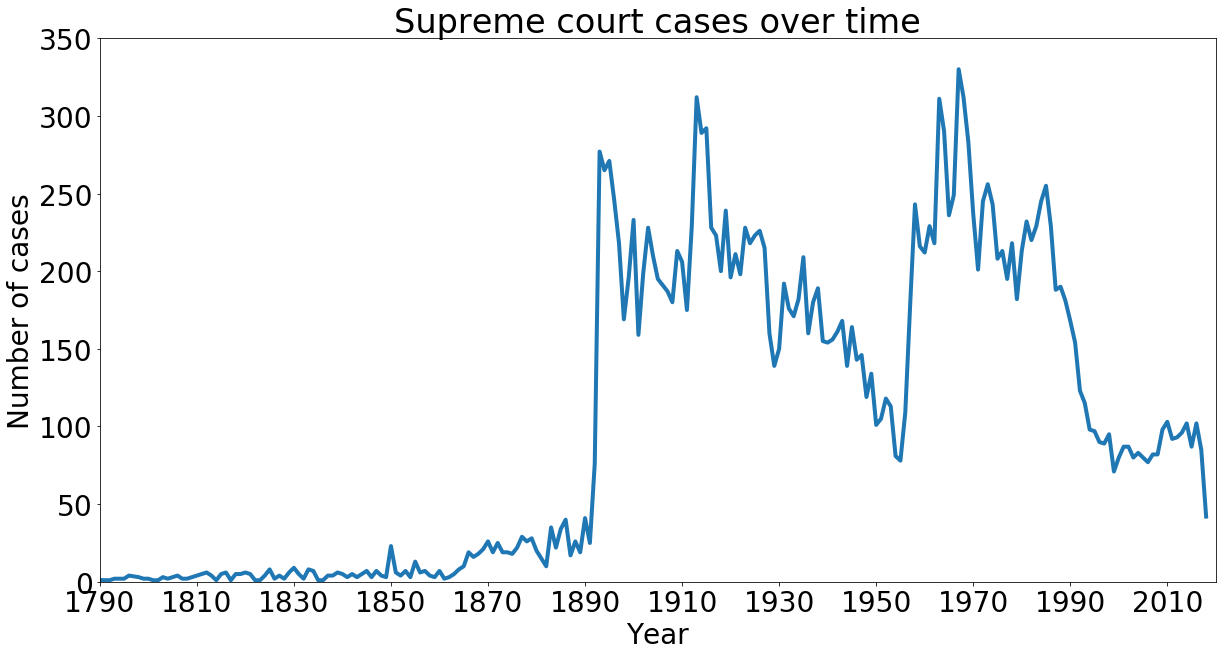

In [38]:
#graph number of cases over time

import matplotlib.pyplot as plt
%matplotlib inline

years = []
for i in range(1790, 2020, 20):
    years.append(i)

plt.rcParams.update({'font.size': 28})    

plt.figure(figsize=(20,10))
plt.title('Supreme court cases over time')
plt.ylabel('Number of cases')
plt.xlabel('Year')
plt.xlim(1790, 2020)
plt.ylim(0,350)
plt.xticks(years)
plt.plot(df["year"],df["number"], linewidth = 4.0);
